This notebook is to train a Variational Autoencoder on Model Parameters dataset, but align the latent variables with the angle of the corresponding model.

In [1]:
import torch
import torch.nn as nn

import numpy as np

from src.data.datasets import ModelParamsDataset

from src.data.generators import get_moons_dataset
from src.data.samplers import sample_gaussian
from src.model.models import DBModelSmall, VAE

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.visualization.visualize import plot_decision_boundary

from torch.utils.data import DataLoader

import math

In [2]:
def loss_fn(x, x_hat, mean, log_var, kdl_weight=40):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kdl_weight*KLD

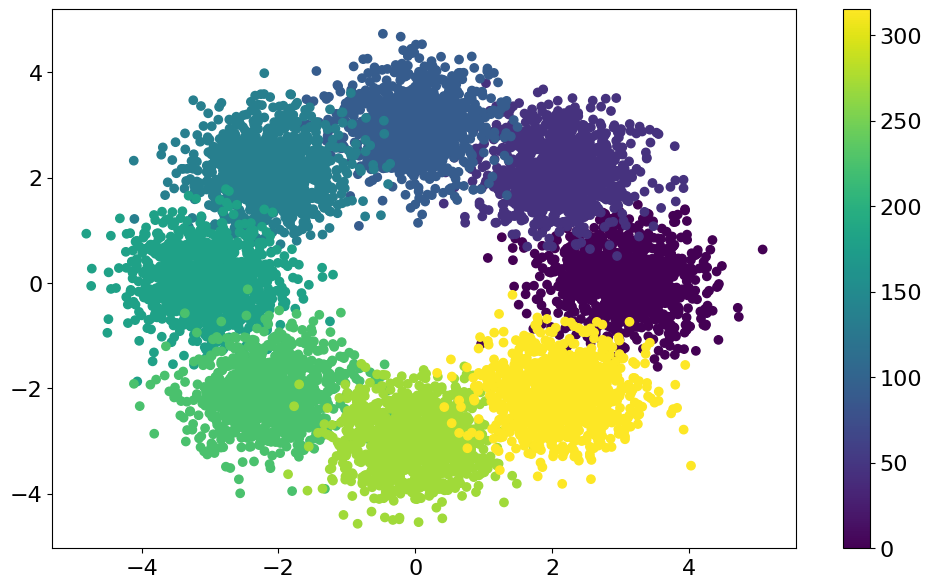

In [4]:
plt.rcParams.update({'font.size': 16})
n_samples = 1000
angles = [0] * n_samples + [45] * n_samples + [90] * n_samples + [135] * n_samples + [180] * n_samples + [225] * n_samples + [270] * n_samples + [315] * n_samples
centers = [(np.cos(a * np.pi / 180), np.sin(a * np.pi / 180)) for a in angles]
centers = torch.tensor(centers).reshape(-1, 2)
r = sample_gaussian(centers, scale=3, var=0.1)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(r[:, 0], r[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

## 10000 samples per angle

In [7]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModelSmall()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae.pth".format(path, kdl_weight)

In [ ]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = sample_gaussian(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

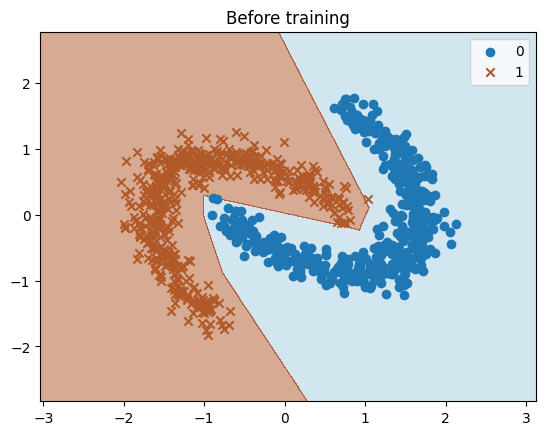

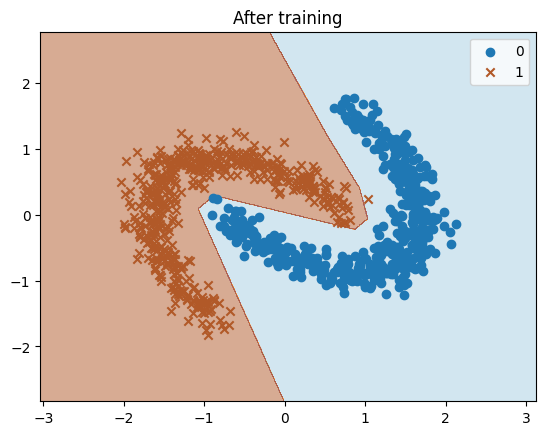

In [9]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
model = DBModelSmall(batch_first=False)

index = 12250
sample = sample_gaussian(torch.tensor([[1, 1]]), scale=3, var=0.1)

parameters = dataset[index][0]
angle = dataset[index][1].item()
reconstructed, _, _ = autoencoder(parameters.unsqueeze(0))
reconstructed = reconstructed.squeeze()
X, y = get_moons_dataset(angle)
model.set_weights(parameters)
plot_decision_boundary(model, X, y, title="Before training")
model.set_weights(reconstructed)
plot_decision_boundary(model, X, y, title="After training")

## 10 spa

In [5]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModelSmall()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_10spa.pth".format(path, kdl_weight)

In [14]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = sample_gaussian(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 3483845.75
Epoch 1 - Loss: 3350179.3125
Epoch 2 - Loss: 3475621.9375
Epoch 3 - Loss: 2712955.0625
Epoch 4 - Loss: 2607510.25
Epoch 5 - Loss: 2742751.0625
Epoch 6 - Loss: 2532266.4375
Epoch 7 - Loss: 2372349.1875
Epoch 8 - Loss: 2567751.0
Epoch 9 - Loss: 2414054.4375
Epoch 10 - Loss: 2941187.0625
Epoch 11 - Loss: 2373979.9375
Epoch 12 - Loss: 2146280.25
Epoch 13 - Loss: 2199367.125
Epoch 14 - Loss: 2400712.875
Epoch 15 - Loss: 2283621.875
Epoch 16 - Loss: 2244010.53125
Epoch 17 - Loss: 2267909.0625
Epoch 18 - Loss: 2153226.0625
Epoch 19 - Loss: 1986107.4375
Epoch 20 - Loss: 1952114.90625
Epoch 21 - Loss: 2132469.53125
Epoch 22 - Loss: 2009544.71875
Epoch 23 - Loss: 1947833.3125
Epoch 24 - Loss: 2088297.5625
Epoch 25 - Loss: 2009689.65625
Epoch 26 - Loss: 2043641.0625
Epoch 27 - Loss: 1944094.8125
Epoch 28 - Loss: 1987423.15625
Epoch 29 - Loss: 1947128.75
Epoch 30 - Loss: 1978905.21875
Epoch 31 - Loss: 1996732.125
Epoch 32 - Loss: 2043847.4375
Epoch 33 - Loss: 2112909.031

## 100 spa

In [15]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModelSmall()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_100spa.pth".format(path, kdl_weight)

In [16]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = sample_gaussian(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 13211792.125
Epoch 1 - Loss: 12576786.0
Epoch 2 - Loss: 11577158.0
Epoch 3 - Loss: 11034052.625
Epoch 4 - Loss: 10520746.375
Epoch 5 - Loss: 10110260.5
Epoch 6 - Loss: 9763436.5
Epoch 7 - Loss: 9429078.375
Epoch 8 - Loss: 9164891.375
Epoch 9 - Loss: 8739931.9375
Epoch 10 - Loss: 8460903.75
Epoch 11 - Loss: 8447883.8125
Epoch 12 - Loss: 8429825.4375
Epoch 13 - Loss: 8192282.375
Epoch 14 - Loss: 8310021.3125
Epoch 15 - Loss: 8082773.625
Epoch 16 - Loss: 7930415.0
Epoch 17 - Loss: 8199219.6875
Epoch 18 - Loss: 7908164.25
Epoch 19 - Loss: 7706969.125
Epoch 20 - Loss: 7853447.9375
Epoch 21 - Loss: 7497313.1875
Epoch 22 - Loss: 7598113.625
Epoch 23 - Loss: 7436147.9375
Epoch 24 - Loss: 7286505.25
Epoch 25 - Loss: 7165841.75
Epoch 26 - Loss: 6948595.9375
Epoch 27 - Loss: 6714287.75
Epoch 28 - Loss: 6602436.0
Epoch 29 - Loss: 6330209.0625
Epoch 30 - Loss: 6121021.3125
Epoch 31 - Loss: 6193095.8125
Epoch 32 - Loss: 5972482.9375
Epoch 33 - Loss: 5614578.125
Epoch 34 - Loss: 53041

## 1000 spa

In [30]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModelSmall()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_1000spa.pth".format(path, kdl_weight)

In [18]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = sample_gaussian(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        model.set_weights(reconstructed)
        output = model(input)

        # Ground truth
        model.set_weights(parameters_batch)
        goal = model(input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 108411622.375
Epoch 1 - Loss: 84794594.625
Epoch 2 - Loss: 75160869.4375
Epoch 3 - Loss: 60675728.1875
Epoch 4 - Loss: 50538176.1875
Epoch 5 - Loss: 45566093.0
Epoch 6 - Loss: 42043060.84375
Epoch 7 - Loss: 39607100.71875
Epoch 8 - Loss: 37475428.1875
Epoch 9 - Loss: 35200041.125
Epoch 10 - Loss: 34338840.5625
Epoch 11 - Loss: 32107155.46875
Epoch 12 - Loss: 30562545.125
Epoch 13 - Loss: 29860939.0625
Epoch 14 - Loss: 28466877.28125
Epoch 15 - Loss: 27470175.3125
Epoch 16 - Loss: 26220639.4375
Epoch 17 - Loss: 26081472.5625
Epoch 18 - Loss: 28575900.6875
Epoch 19 - Loss: 25155010.0
Epoch 20 - Loss: 23787174.28125
Epoch 21 - Loss: 24759558.65625
Epoch 22 - Loss: 26175407.703125
Epoch 23 - Loss: 26478976.875
Epoch 24 - Loss: 22377774.75
Epoch 25 - Loss: 23511894.515625
Epoch 26 - Loss: 22150078.984375
Epoch 27 - Loss: 21048911.640625
Epoch 28 - Loss: 21311955.40625
Epoch 29 - Loss: 21011185.859375
Epoch 30 - Loss: 19817945.53125
Epoch 31 - Loss: 21238277.28125
Epoch 32 - 

## Latent Space

(80000, 2)


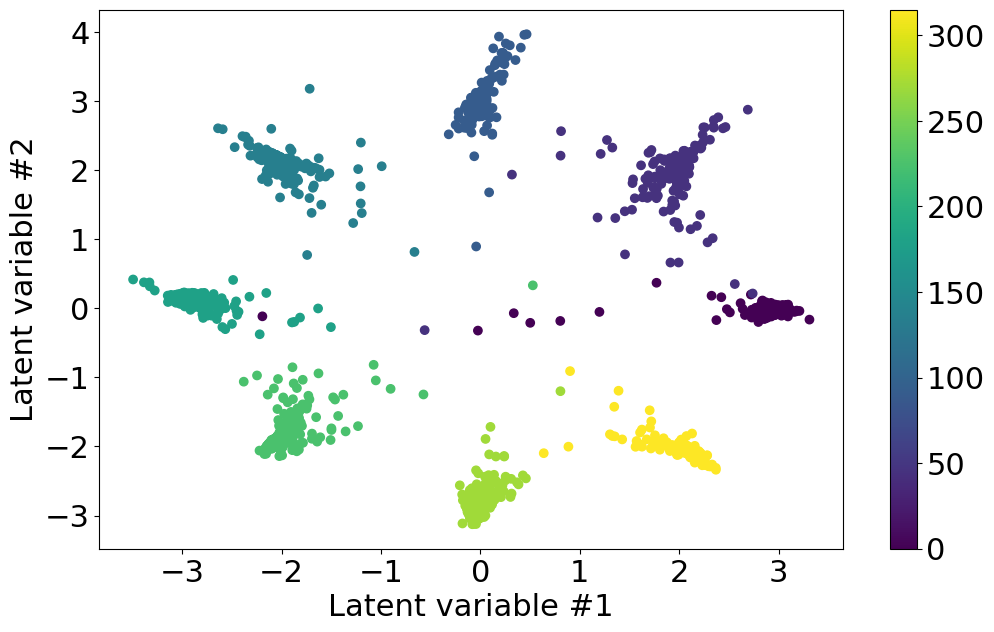

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Make text bigger in the plot
plt.rcParams.update({'font.size': 22})

model_path = "../../models/autoencoders/vae_dbloss_aligned/vae.pth"
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/zoo_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

raw_unseen = pd.read_csv("../../data/extra_angles.csv")
weights_unseen = raw_unseen.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles_unseen = raw_unseen["angle"].to_numpy()

# Join both weights
# weights = np.vstack([weights, weights_unseen])
# angles = np.hstack([angles, angles_unseen])

weights = torch.tensor(weights).float()
latent, mean, logvar = autoencoder(weights)
latent = autoencoder.reparameterize(mean, logvar).detach().numpy()
latent = mean.detach().numpy()
print(latent.shape)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


# plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.savefig("../../reports/vae-latent-space-mini.pdf", bbox_inches='tight')
plt.show()